## RNN을 이용한 텍스트 생성(Text Generation using RNN)
- https://wikidocs.net/45101
- 다 대 일(many-to-one) 구조의 RNN을 사용하여 문맥을 반영해서 텍스트를 생성하는 모델

### RNN을 이용하여 텍스트 생성하기
- 예)세 가지 문장
    - 경마장에 있는 말이 뛰고 있다
    - 그의 말이 법이다
    - 가는 말이 고와야 오는 말이 곱다
- 전체 문장의 앞의 단어들을 전부 고려하여 학습하도록 데이터를 재구성하면 -> 11개 샘플
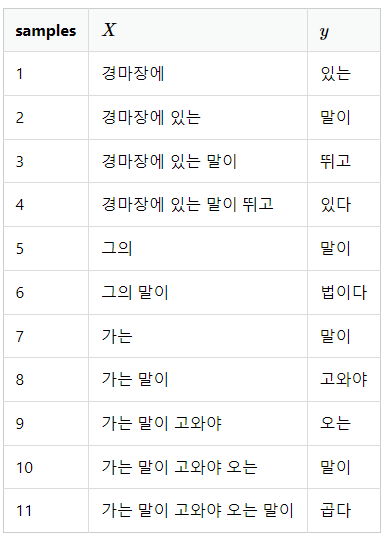

#### 데이터에 대한 이해와 전처리

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 위한 0을 고려하여 +1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 12


In [7]:
# 각 단어와 단어에 부여된 정수 인덱스를 출력
print(tokenizer.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [8]:
# 훈련 데이터 생성
sequences = list()
for line in text.split('\n'): # 줄바꿈 문자를 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))

학습에 사용할 샘플의 개수: 11


In [9]:
# 전체 샘플 출력
print(sequences)

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


- 아직 레이블로 사용될 단어를 분리하지 않은 훈련 데이터
    - [2, 3]은 [경마장에, 있는]
    - [2, 3, 1]은 [경마장에, 있는, 말이]
- 맨 우측에 있는 단어에 대해서만 레이블로 분리
    - [2, 3]은 [경마장에, 있는] -> 있는 을 레이블로

- 전체 샘플에 대해서 길이를 일치 시켜줌
    - 가장 긴 샘플의 길이를 기준으로 진행

In [10]:
# 코드로도 확인 가능
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


In [12]:
# 전체 샘플의 길이를 6으로 패딩
# padding의 인자로 'pre'를 주면 길이가 6보다 짧은 샘플의 앞에 0으로 채움
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [13]:
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [22]:
# 마지막 단어를 레이블로 분리
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [23]:
X

array([[ 0,  0,  0,  0,  2],
       [ 0,  0,  0,  2,  3],
       [ 0,  0,  2,  3,  1],
       [ 0,  2,  3,  1,  4],
       [ 0,  0,  0,  0,  6],
       [ 0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  8],
       [ 0,  0,  0,  8,  1],
       [ 0,  0,  8,  1,  9],
       [ 0,  8,  1,  9, 10],
       [ 8,  1,  9, 10,  1]])

In [24]:
y 

array([ 3,  1,  4,  5,  1,  7,  1,  9, 10,  1, 11])

In [25]:
# 원-핫 인코딩 수행
y = to_categorical(y, num_classes=vocab_size)
y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

#### 모델 설계하기

In [26]:
# RNN 모델에 데이터를 훈련
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

- 하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 32
- 다 대 일 구조의 RNN을 사용
- 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델
    - 다중 클래스 분류 -> 활성화 함수: 소프트맥스
    - 손실함수: 크로스엔트로피 함수
- 에포크 200

In [27]:
embedding_dim = 10
hidden_units = 32

model = Sequential()
# 전결합층(Fully Connected Layer)을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.4914 - accuracy: 0.0000e+00 - 847ms/epoch - 847ms/step
Epoch 2/200
1/1 - 0s - loss: 2.4784 - accuracy: 0.0909 - 3ms/epoch - 3ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4656 - accuracy: 0.2727 - 3ms/epoch - 3ms/step
Epoch 4/200
1/1 - 0s - loss: 2.4530 - accuracy: 0.3636 - 2ms/epoch - 2ms/step
Epoch 5/200
1/1 - 0s - loss: 2.4404 - accuracy: 0.5455 - 3ms/epoch - 3ms/step
Epoch 6/200
1/1 - 0s - loss: 2.4277 - accuracy: 0.5455 - 2ms/epoch - 2ms/step
Epoch 7/200
1/1 - 0s - loss: 2.4147 - accuracy: 0.5455 - 3ms/epoch - 3ms/step
Epoch 8/200
1/1 - 0s - loss: 2.4015 - accuracy: 0.5455 - 3ms/epoch - 3ms/step
Epoch 9/200
1/1 - 0s - loss: 2.3877 - accuracy: 0.5455 - 2ms/epoch - 2ms/step
Epoch 10/200
1/1 - 0s - loss: 2.3734 - accuracy: 0.5455 - 3ms/epoch - 3ms/step
Epoch 11/200
1/1 - 0s - loss: 2.3585 - accuracy: 0.5455 - 4ms/epoch - 4ms/step
Epoch 12/200
1/1 - 0s - loss: 2.3428 - accuracy: 0.5455 - 3ms/epoch - 3ms/step
Epoch 13/200
1/1 - 0s - loss: 2.3262 - accuracy: 0.54

Epoch 105/200
1/1 - 0s - loss: 0.6785 - accuracy: 0.8182 - 2ms/epoch - 2ms/step
Epoch 106/200
1/1 - 0s - loss: 0.6678 - accuracy: 0.8182 - 2ms/epoch - 2ms/step
Epoch 107/200
1/1 - 0s - loss: 0.6572 - accuracy: 0.8182 - 3ms/epoch - 3ms/step
Epoch 108/200
1/1 - 0s - loss: 0.6469 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 109/200
1/1 - 0s - loss: 0.6367 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 110/200
1/1 - 0s - loss: 0.6266 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 111/200
1/1 - 0s - loss: 0.6168 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 112/200
1/1 - 0s - loss: 0.6070 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 113/200
1/1 - 0s - loss: 0.5975 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 114/200
1/1 - 0s - loss: 0.5880 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 115/200
1/1 - 0s - loss: 0.5788 - accuracy: 0.9091 - 1ms/epoch - 1ms/step
Epoch 116/200
1/1 - 0s - loss: 0.5697 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 117/200
1/1 - 0s - loss: 0.5607 - 

In [28]:
# 문장 생성하는 함수
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면 break
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [29]:
#  '경마장에' 라는 단어 뒤에는 총 4개의 단어가 있으므로 4번 예측
print(sentence_generation(model, tokenizer, '경마장에', 4))

경마장에 있는 말이 뛰고 있다


In [33]:
print(sentence_generation(model, tokenizer, '그의', 2))

그의 말이 법이다


In [34]:
print(sentence_generation(model, tokenizer, '가는', 5))

가는 말이 고와야 오는 말이 곱다


- '말이' 다음 단어 정확하게 예측
- 문장 길이에 맞게 4, 2, 5 인자값 줌
- 그 이상 값 주면 그 다음에 올 단어를 임의로 예측

In [36]:
print(sentence_generation(model, tokenizer, '그의', 3))

그의 말이 법이다 오는


### LSTM을 이용하여 텍스트 생성하기
- 더 많은 데이터로 텍스트 생성
- 본질적으로는 앞 실습과 동일

#### 데이터에 대한 이해와 전처리
- 데이터: 뉴욕 타임즈 기사의 제목

In [37]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [38]:
df = pd.read_csv('ArticlesApril2018.csv')

In [39]:
df.head(1)

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...


In [ ]:
# 15개 열 존재
# 사용할 열 : headline 열

In [40]:
print('열의 개수: ',len(df.columns))
print(df.columns)

열의 개수:  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [41]:
# null 없음
print(df['headline'].isnull().values.any())

False


In [42]:
headline = []
# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values)) 
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [43]:
headline = [word for word in headline if word != "Unknown"]

In [44]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [45]:
# 구두점 제거와 단어의 소문자화
def repreprocessing(raw_sentence):
    preproceseed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preproceseed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [46]:
# 단어 집합(vocabulary)을 만들고 크기를 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


In [47]:
# 훈련 데이터를 구성
sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

- 하나의 단어를 예측하기 위해 이전에 등장한 단어들을 모두 참고
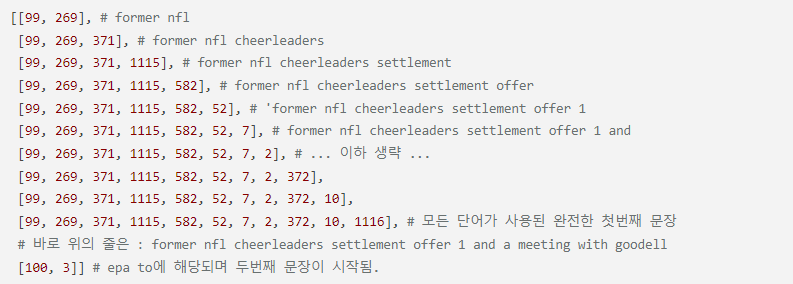

In [48]:
# 어떤 정수가 어떤 단어를 의미하는지 알아보기 위해 인덱스로부터 단어를 찾는 index_to_word 생성
index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [50]:
# 전체 샘플 동일하게 만드는 패딩 작업 수행
# 가장 긴 샘플 길이 확인
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [51]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [52]:
# 레이블 분리
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [53]:
print(X[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


In [54]:
print(y[:3])

[ 269  371 1115]


In [55]:
# 레이블 원-핫 인코딩 수행
y = to_categorical(y, num_classes=vocab_size)

#### 모델 설계하기

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

- 하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 128
- 다 대 일 구조의 LSTM 사용
- 나머지 조건은 위(RNN실습)와 같음

In [57]:
embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 5s - loss: 7.6437 - accuracy: 0.0264 - 5s/epoch - 21ms/step
Epoch 2/200
244/244 - 3s - loss: 7.1182 - accuracy: 0.0288 - 3s/epoch - 14ms/step
Epoch 3/200
244/244 - 3s - loss: 6.9791 - accuracy: 0.0320 - 3s/epoch - 14ms/step
Epoch 4/200
244/244 - 4s - loss: 6.8567 - accuracy: 0.0411 - 4s/epoch - 15ms/step
Epoch 5/200
244/244 - 4s - loss: 6.7139 - accuracy: 0.0428 - 4s/epoch - 14ms/step
Epoch 6/200
244/244 - 3s - loss: 6.5546 - accuracy: 0.0470 - 3s/epoch - 14ms/step
Epoch 7/200
244/244 - 3s - loss: 6.3832 - accuracy: 0.0511 - 3s/epoch - 14ms/step
Epoch 8/200
244/244 - 3s - loss: 6.2037 - accuracy: 0.0556 - 3s/epoch - 14ms/step
Epoch 9/200
244/244 - 3s - loss: 6.0182 - accuracy: 0.0582 - 3s/epoch - 13ms/step
Epoch 10/200
244/244 - 3s - loss: 5.8346 - accuracy: 0.0669 - 3s/epoch - 14ms/step
Epoch 11/200
244/244 - 3s - loss: 5.6636 - accuracy: 0.0701 - 3s/epoch - 14ms/step
Epoch 12/200
244/244 - 3s - loss: 5.4975 - accuracy: 0.0741 - 3s/epoch - 14ms/step
Epoch 13/200


Epoch 100/200
244/244 - 4s - loss: 0.7443 - accuracy: 0.8527 - 4s/epoch - 15ms/step
Epoch 101/200
244/244 - 4s - loss: 0.7293 - accuracy: 0.8531 - 4s/epoch - 15ms/step
Epoch 102/200
244/244 - 4s - loss: 0.7157 - accuracy: 0.8570 - 4s/epoch - 15ms/step
Epoch 103/200
244/244 - 4s - loss: 0.7001 - accuracy: 0.8616 - 4s/epoch - 15ms/step
Epoch 104/200
244/244 - 3s - loss: 0.6850 - accuracy: 0.8611 - 3s/epoch - 14ms/step
Epoch 105/200
244/244 - 4s - loss: 0.6735 - accuracy: 0.8634 - 4s/epoch - 15ms/step
Epoch 106/200
244/244 - 4s - loss: 0.6603 - accuracy: 0.8666 - 4s/epoch - 15ms/step
Epoch 107/200
244/244 - 3s - loss: 0.6492 - accuracy: 0.8697 - 3s/epoch - 14ms/step
Epoch 108/200
244/244 - 3s - loss: 0.6346 - accuracy: 0.8721 - 3s/epoch - 14ms/step
Epoch 109/200
244/244 - 3s - loss: 0.6205 - accuracy: 0.8761 - 3s/epoch - 14ms/step
Epoch 110/200
244/244 - 3s - loss: 0.6077 - accuracy: 0.8770 - 3s/epoch - 14ms/step
Epoch 111/200
244/244 - 3s - loss: 0.5963 - accuracy: 0.8794 - 3s/epoch - 14

Epoch 198/200
244/244 - 3s - loss: 0.2791 - accuracy: 0.9158 - 3s/epoch - 14ms/step
Epoch 199/200
244/244 - 3s - loss: 0.2693 - accuracy: 0.9171 - 3s/epoch - 14ms/step
Epoch 200/200
244/244 - 3s - loss: 0.2654 - accuracy: 0.9168 - 3s/epoch - 14ms/step


In [58]:
# 문장 생성하는 함수 생성
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [59]:
print(sentence_generation(model, tokenizer, 'i', 10))

i disapprove of school vouchers can i still apply for them


In [60]:
print(sentence_generation(model, tokenizer, 'how', 10))

how to prevent a racist hoodie of made a broken gun
